In [15]:
import glob
import os
import omegaconf

import pandas as pd
import numpy as np
import random

import logging

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.decomposition import PCA

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [16]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/synesthetes/participants.csv"
embeddings_subpath = "synesthetes_random_embeddings/full_embeddings.csv"
ukb_embeddings_subpath = "ukb_random_embeddings/full_embeddings.csv"
participants_ukb_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants.csv"
output_filename = f"{path_champollion}/summary/isSynesthete_without_residualization.csv"
label = "isSynesthete"
covariates = ["Sex", "Age", "brain_volume"]
max_iter = 2000
cv = 3

In [17]:
participants = pd.read_csv(participants_file, index_col=0)


In [18]:
participants.head()

,brain_volume,isSynesthete,NOM,DDN,IRM name,Date IRM,Age,Sex,Lateralite,Remarques,Code BV,Unnamed: 9,0=femme – 1=homme,0=droitier – 1=gaucher
participant_id,,,,,,,,,,,,,,
mv_SYNESTHEX_Sujet09_Session1_S2_T1w,1261229.989,0,PECL,12/8/1998,Control02,NaN,25.000000,1,0,Pas analysé,Sujet9,NaN,NaN,NaN
mv_SYNESTHEX_Sujet10_Session2_S14_T1w,1229268.222,0,VIMA,18/3/1985,Control27,28/2/2023,37.975342,0,0,NaN,Sujet10,NaN,NaN,NaN
mv_SYNESTHEX_Sujet11_Session2_S14_T1w,1026066.763,1,SICA,17/8/1985,Sujet23,3/3/2023,37.567123,0,0,NaN,Sujet11,NaN,NaN,NaN
mv_SYNESTHEX_Sujet12_Session2_S12_T1w,1164323.992,1,HACL,10/6/1972,Sujet24,29/3/2023,50.832877,0,0,NaN,Sujet12,NaN,NaN,NaN
mv_SYNESTHEX_Sujet13_Session2_S13_T1w,1127962.029,1,HELI,2/11/1966,Sujet25,20/5/2023,56.583562,0,0,NaN,Sujet13,NaN,NaN,NaN


In [19]:
participants = participants[["isSynesthete", "brain_volume", "Age", "Sex"]]

In [20]:
# participants[:] = participants.sample(frac=1).values

In [21]:
participants

,isSynesthete,brain_volume,Age,Sex
participant_id,,,,
mv_SYNESTHEX_Sujet09_Session1_S2_T1w,0,1261229.989,25.000000,1
mv_SYNESTHEX_Sujet10_Session2_S14_T1w,0,1229268.222,37.975342,0
mv_SYNESTHEX_Sujet11_Session2_S14_T1w,1,1026066.763,37.567123,0
mv_SYNESTHEX_Sujet12_Session2_S12_T1w,1,1164323.992,50.832877,0
mv_SYNESTHEX_Sujet13_Session2_S13_T1w,1,1127962.029,56.583562,0
mv_SYNESTHEX_Sujet14_Session2_S12_T1w,1,1111493.520,59.657534,0
mv_SYNESTHEX_Sujet15_Session2_S13_T1w,0,1249955.184,19.104110,0
mv_SYNESTHEX_Sujet16_Session1_S2_T1w,0,1228108.519,33.000000,1
mv_SYNESTHEX_Sujet17_session1_S2_T1w,0,1198256.646,28.000000,0


array([[<Axes: title={'center': 'isSynesthete'}>,
        <Axes: title={'center': 'brain_volume'}>],
       [<Axes: title={'center': 'Age'}>, <Axes: title={'center': 'Sex'}>]],
      dtype=object)

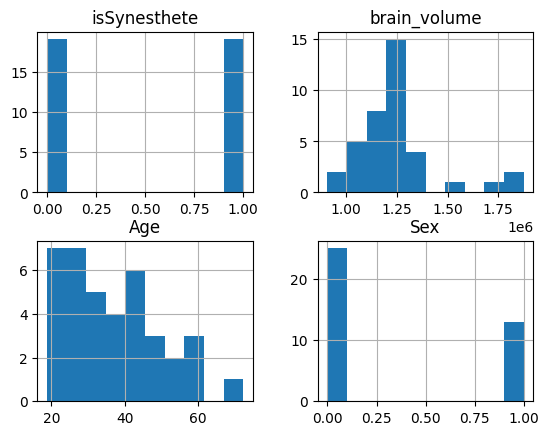

In [22]:
participants.hist()

array([[<Axes: title={'center': 'Sex'}>, <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'brain_volume'}>, <Axes: >]], dtype=object)

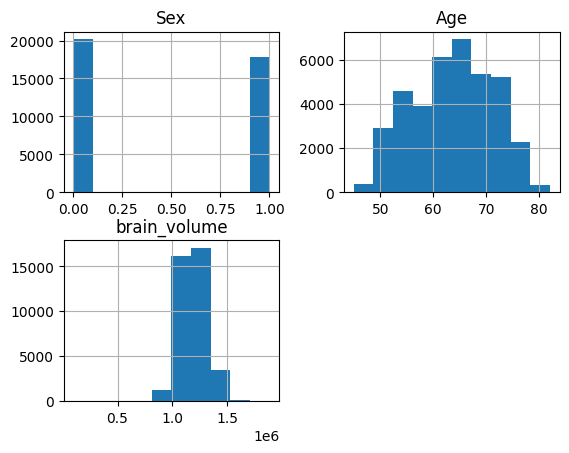

In [23]:
participants_ukb = pd.read_csv(participants_ukb_file, index_col=0)
participants_ukb = participants_ukb[["Sex", "Age", "BrainVolumeFreeSurfer_mm3"]].rename(columns={"BrainVolumeFreeSurfer_mm3": "brain_volume"})
participants_ukb.hist()

In [24]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result

In [25]:
model_paths = get_model_paths(path_champollion)

In [26]:
models_df = pd.DataFrame({"path":model_paths})

In [27]:
# df = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
# pca = PCA(n_components=1)
# df2 = pd.DataFrame(pca.fit_transform(df))
# df2.index = df.index
# df2


In [28]:
def compute(model_path, random_state):
    global embeddings
    global participants
    global results, X, Y, df2
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
    merged = participants[[label] + covariates].merge(embeddings, left_index=True, right_index=True)

    # Residualizes using ukb embeddings
    embeddings_ukb = pd.read_csv(f"{model_path}/{ukb_embeddings_subpath}", index_col=0)
    phenotypes_cols = embeddings_ukb.columns # Supposes that phenotype names are identical
    merged_ukb = participants_ukb[covariates].merge(embeddings_ukb, left_index=True, right_index=True)
    
    resid_df = merged[[label]].copy()
    resid_df.loc[:, phenotypes_cols] = 0.0
    resid_df_ukb = merged_ukb[covariates].copy()
    resid_df_ukb.loc[:, phenotypes_cols] = 0.0

    for dim_i in phenotypes_cols:
        X = merged_ukb[covariates]
        X = sm.add_constant(X)
        y = merged_ukb[dim_i]
        model = sm.OLS(y, X).fit()
        ypred = model.predict(X)
        residuals = y - ypred
        resid_df_ukb.loc[:, dim_i] = residuals

        X = merged[covariates]
        X = sm.add_constant(X)
        y = merged[dim_i]
        ypred = model.predict(X)
        residuals = y - ypred
        resid_df.loc[:, dim_i] = residuals

    # Merge
    merged = participants[[label]].merge(resid_df[phenotypes_cols], left_index=True, right_index=True)

    # Makes PCA on UkBioBank residuals
    pca = PCA(n_components=3)
    pca.fit(resid_df_ukb.loc[:, phenotypes_cols])

    # Gets synesthete residuals
    X = resid_df.loc[:, phenotypes_cols]
    Y = resid_df[[label]]

    # Transforms in synesthete dataset
    df2 = pd.DataFrame(pca.transform(X))
    df2.index = X.index

    # Makes OLS
    df2 = sm.add_constant(df2)
    model = sm.OLS(Y[label], df2)
    results = model.fit()
    f_value = results.fvalue
    p_value = results.f_pvalue
    predictions = results.predict(df2)

    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(f_value, p_value)
    
    # Returns result
    return (region, predictions, Y)

In [29]:
participants.dtypes

isSynesthete      int64
brain_volume    float64
Age             float64
Sex               int64
dtype: object

In [30]:
result = pd.DataFrame({})
for random_state in range(5):

    # Computes AUC
    for model_path in model_paths:
        ret = compute(model_path, random_state)
        f = ret[1].to_frame().T
        f.insert(0, "region", [ret[0]])
        result = pd.concat([result, f]).reset_index(drop=True)
        Y = ret[2]

Treating S.C.-sylv._left: SC-sylv_left/11-43-38_2 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2
1.409361056280677 0.2569154426668064
Treating S.C.-sylv._left: SC-sylv_left/14-00-57_116 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116
0.6550010325806019 0.5853869666648895
Treating S.F.inter.-S.F.sup._left: SFinter-SFsup_left/09-33-02_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0
0.06906090253529285 0.9760325219180163
Treating S.T.i.-S.T.s.-S.T.pol._right: STi-STs-STpol_right/20-15-00_117 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117
0.1172487038068037 0.9493694805466699
Treating F.Coll.-S.Rh._right: FColl-SRh_right/09-45-57_1 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1
0.04491126222136668 0.9871342974127206
Treating S.T.s.-S.GSM._left: STs-SGSM_left/

In [31]:
result

,region,mv_SYNESTHEX_Sujet09_Session1_S2_T1w,mv_SYNESTHEX_Sujet10_Session2_S14_T1w,mv_SYNESTHEX_Sujet11_Session2_S14_T1w,mv_SYNESTHEX_Sujet12_Session2_S12_T1w,mv_SYNESTHEX_Sujet13_Session2_S13_T1w,mv_SYNESTHEX_Sujet14_Session2_S12_T1w,mv_SYNESTHEX_Sujet15_Session2_S13_T1w,mv_SYNESTHEX_Sujet16_Session1_S2_T1w,mv_SYNESTHEX_Sujet17_session1_S2_T1w,...,mv_SYNESTHEX_Sujet19_Session1_S3_T1w,mv_SYNESTHEX_Sujet20_Session1_S2_T1w,mv_SYNESTHEX_Sujet21_Session1_S2_T1w,mv_SYNESTHEX_Sujet22_Session1_S2_T1w,mv_SYNESTHEX_Sujet23_Session1_S3_T1w,mv_SYNESTHEX_Sujet24_Session1_S2_T1w,mv_SYNESTHEX_Sujet25_Session1_S2_T1w,mv_SYNESTHEX_Sujet26_Session1_S2_T1w,mv_SYNESTHEX_Sujet27_Session1_S2_T1w,mv_SYNESTHEX_Sujet28_Session1_S2_T1w
0,S.C.-sylv._left,0.635016,0.455894,0.727434,0.812033,0.719584,0.652327,0.778106,0.410995,0.453199,...,0.292991,0.388864,0.352969,0.613939,0.364377,0.754064,0.414593,0.414277,0.392096,0.554363
1,S.C.-sylv._left,0.570366,0.500835,0.689349,0.572976,0.633974,0.428318,0.674178,0.401070,0.586639,...,0.355704,0.352069,0.563723,0.549644,0.281815,0.640945,0.441169,0.477268,0.411812,0.537705
2,S.F.inter.-S.F.sup._left,0.521123,0.449177,0.517344,0.517052,0.496471,0.439325,0.459220,0.550556,0.543496,...,0.534634,0.594648,0.452051,0.467049,0.513728,0.509476,0.515055,0.564163,0.490490,0.482145
3,S.T.i.-S.T.s.-S.T.pol._right,0.524994,0.500104,0.484044,0.430391,0.555259,0.477142,0.518952,0.545844,0.441664,...,0.509783,0.510955,0.479511,0.564830,0.512984,0.594489,0.527413,0.435967,0.394093,0.472034
4,F.Coll.-S.Rh._right,0.506240,0.503537,0.498604,0.533290,0.559313,0.547218,0.460914,0.511392,0.495672,...,0.469307,0.455509,0.488148,0.516815,0.521442,0.489105,0.533955,0.529417,0.548161,0.539445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,S.C.-S.Po.C._left,0.459252,0.545311,0.567017,0.498973,0.597774,0.677865,0.579878,0.417269,0.336107,...,0.498317,0.526979,0.523546,0.408396,0.514632,0.664226,0.461968,0.414308,0.550244,0.476960
486,S.C.-S.Po.C._left,0.585834,0.635454,0.576762,0.724887,0.439693,0.533600,0.467935,0.478787,0.475497,...,0.484756,0.470309,0.476547,0.582143,0.512706,0.319621,0.532762,0.384832,0.534715,0.682334
487,S.C.-S.Po.C._left,0.644281,0.792870,0.707191,0.783070,0.391517,0.586422,0.419074,0.390816,0.423132,...,0.472945,0.325788,0.245504,0.900062,0.233039,0.251260,0.586598,0.415217,0.496721,0.671486
488,S.C.-S.Po.C._left,0.429966,0.501327,0.540803,0.516814,0.576323,0.603977,0.686128,0.378168,0.507128,...,0.441604,0.462708,0.479083,0.458397,0.589591,0.687686,0.377479,0.466227,0.500774,0.539110


In [32]:
ensemble = result.groupby("region").mean()

In [33]:
ensemble

,mv_SYNESTHEX_Sujet09_Session1_S2_T1w,mv_SYNESTHEX_Sujet10_Session2_S14_T1w,mv_SYNESTHEX_Sujet11_Session2_S14_T1w,mv_SYNESTHEX_Sujet12_Session2_S12_T1w,mv_SYNESTHEX_Sujet13_Session2_S13_T1w,mv_SYNESTHEX_Sujet14_Session2_S12_T1w,mv_SYNESTHEX_Sujet15_Session2_S13_T1w,mv_SYNESTHEX_Sujet16_Session1_S2_T1w,mv_SYNESTHEX_Sujet17_session1_S2_T1w,mv_SYNESTHEX_Sujet18_Session1_S4_T1w,...,mv_SYNESTHEX_Sujet19_Session1_S3_T1w,mv_SYNESTHEX_Sujet20_Session1_S2_T1w,mv_SYNESTHEX_Sujet21_Session1_S2_T1w,mv_SYNESTHEX_Sujet22_Session1_S2_T1w,mv_SYNESTHEX_Sujet23_Session1_S3_T1w,mv_SYNESTHEX_Sujet24_Session1_S2_T1w,mv_SYNESTHEX_Sujet25_Session1_S2_T1w,mv_SYNESTHEX_Sujet26_Session1_S2_T1w,mv_SYNESTHEX_Sujet27_Session1_S2_T1w,mv_SYNESTHEX_Sujet28_Session1_S2_T1w
region,,,,,,,,,,,,,,,,,,,,,
CINGULATE_left,0.407952,0.659072,0.491236,0.648879,0.561964,0.440227,0.526726,0.462515,0.418086,0.451039,...,0.357160,0.564649,0.374140,0.527286,0.458068,0.399418,0.666879,0.355634,0.554530,0.597313
CINGULATE_right,0.443135,0.375714,0.507099,0.659036,0.436943,0.644772,0.430274,0.451208,0.281642,0.553248,...,0.397857,0.553420,0.594102,0.305736,0.649595,0.522017,0.425719,0.549426,0.764329,0.272418
F.C.L.p.-S.GSM._left,0.478241,0.537209,0.636879,0.611906,0.484485,0.400329,0.616760,0.436985,0.426298,0.619887,...,0.360989,0.583204,0.554210,0.389272,0.390036,0.564065,0.491143,0.406573,0.514584,0.408214
F.C.L.p.-S.GSM._right,0.457483,0.479539,0.662979,0.373202,0.539031,0.405645,0.615491,0.389538,0.618130,0.473098,...,0.557638,0.506529,0.476401,0.592477,0.471888,0.503178,0.539935,0.494527,0.469763,0.460854
F.C.L.p.-subsc.-F.C.L.a.-INSULA._left,0.565642,0.548180,0.675603,0.548228,0.444620,0.419548,0.620738,0.326321,0.407791,0.519816,...,0.434750,0.556191,0.530533,0.456643,0.270628,0.607416,0.554534,0.342514,0.580791,0.358754
F.C.L.p.-subsc.-F.C.L.a.-INSULA._right,0.446331,0.464471,0.666616,0.333554,0.562745,0.391061,0.662926,0.382284,0.615707,0.478592,...,0.508450,0.521394,0.442123,0.612059,0.467803,0.584435,0.568218,0.471461,0.399304,0.420199
F.C.M.post.-S.p.C._left,0.485152,0.611617,0.495620,0.778430,0.593148,0.473874,0.628532,0.456760,0.419661,0.397514,...,0.449242,0.577329,0.398886,0.561213,0.524706,0.268107,0.656114,0.430127,0.556927,0.660301
F.C.M.post.-S.p.C._right,0.499625,0.552061,0.396540,0.520892,0.599088,0.597245,0.374501,0.361205,0.381332,0.504648,...,0.726133,0.525268,0.611136,0.381745,0.514546,0.409235,0.685909,0.542085,0.540289,0.545183
F.Coll.-S.Rh._left,0.095085,0.425728,0.747478,0.656743,0.681348,0.806962,0.380624,0.835949,0.091455,0.624360,...,0.425155,0.760647,0.383873,0.765114,0.478653,0.161122,0.817401,0.574472,0.389962,0.351409


In [34]:
res_ensemble = []
for row in ensemble.iterrows():
    df2 = row[1].copy().to_frame()
    df2 = sm.add_constant(df2)
    model = sm.OLS(Y, df2)
    results = model.fit()
    res_ensemble.append((row[0], results.fvalue, results.f_pvalue))

In [35]:
res_ensemble

[('CINGULATE_left', 2.222376303358691, 0.14473439671364968),
 ('CINGULATE_right', 2.449536807136674, 0.12630864382097967),
 ('F.C.L.p.-S.GSM._left', 0.9412335579478038, 0.3384342959097322),
 ('F.C.L.p.-S.GSM._right', 0.9403641944839994, 0.33865462789947953),
 ('F.C.L.p.-subsc.-F.C.L.a.-INSULA._left',
  1.437458769066304,
  0.23838359823073813),
 ('F.C.L.p.-subsc.-F.C.L.a.-INSULA._right',
  1.5935373869098346,
  0.21493813345621957),
 ('F.C.M.post.-S.p.C._left', 2.0821725648659064, 0.15767335948306274),
 ('F.C.M.post.-S.p.C._right', 1.308441774072673, 0.26022623738988054),
 ('F.Coll.-S.Rh._left', 8.906162631438034, 0.005081218069626826),
 ('F.Coll.-S.Rh._right', 0.14265930352668735, 0.7078692971425167),
 ('F.I.P._left', 3.8895305185463336, 0.0563080829599383),
 ('F.I.P._right', 5.028335974039277, 0.031188003427683762),
 ('F.P.O.-S.Cu.-Sc.Cal._left', 4.548938750084184, 0.03982846134289581),
 ('F.P.O.-S.Cu.-Sc.Cal._right', 1.8424260492894493, 0.1831159174173671),
 ('Lobule_parietal_sup._l

In [70]:
Y.shape

(38, 1)

In [86]:
res_auc = []
for row in ensemble.iterrows():
    df2 = row[1].copy().to_frame()
    model = LogisticRegression(max_iter=max_iter, class_weight='balanced')
    res = cross_val_score(model, df2, Y, cv=3, scoring='roc_auc')
    res_auc.append((row[0], res.mean()))

/home/jc225751/Runs/70_self-supervised_two-regions/Program/venv_natif/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jc225751/Runs/70_self-supervised_two-regions/Program/venv_natif/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jc225751/Runs/70_self-supervised_two-regions/Program/venv_natif/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jc225751/Runs/70_self-superv

In [64]:
Y

,isSynesthete
mv_SYNESTHEX_Sujet09_Session1_S2_T1w,0
mv_SYNESTHEX_Sujet10_Session2_S14_T1w,0
mv_SYNESTHEX_Sujet11_Session2_S14_T1w,1
mv_SYNESTHEX_Sujet12_Session2_S12_T1w,1
mv_SYNESTHEX_Sujet13_Session2_S13_T1w,1
mv_SYNESTHEX_Sujet14_Session2_S12_T1w,1
mv_SYNESTHEX_Sujet15_Session2_S13_T1w,0
mv_SYNESTHEX_Sujet16_Session1_S2_T1w,0
mv_SYNESTHEX_Sujet17_session1_S2_T1w,0
mv_SYNESTHEX_Sujet18_Session1_S4_T1w,0


In [57]:
df = pd.DataFrame(res_ensemble, columns=['region', 'f_value', 'p_value'])

In [81]:
df_auc = pd.DataFrame(res_auc, columns=['region', 'auc'])
df_auc.head()

,region,auc
0,CINGULATE_left,0.629167
1,CINGULATE_right,0.612500
2,F.C.L.p.-S.GSM._left,0.583333
3,F.C.L.p.-S.GSM._right,0.583333
4,F.C.L.p.-subsc.-F.C.L.a.-INSULA._left,0.637500


In [37]:
df

,region,f_value,p_value
0,CINGULATE_left,2.222376,0.144734
1,CINGULATE_right,2.449537,0.126309
2,F.C.L.p.-S.GSM._left,0.941234,0.338434
3,F.C.L.p.-S.GSM._right,0.940364,0.338655
4,F.C.L.p.-subsc.-F.C.L.a.-INSULA._left,1.437459,0.238384
5,F.C.L.p.-subsc.-F.C.L.a.-INSULA._right,1.593537,0.214938
6,F.C.M.post.-S.p.C._left,2.082173,0.157673
7,F.C.M.post.-S.p.C._right,1.308442,0.260226
8,F.Coll.-S.Rh._left,8.906163,0.005081
9,F.Coll.-S.Rh._right,0.142659,0.707869


In [87]:
df['side'] = df['region'].str.split('_').str[-1]
df_auc['side'] = df_auc['region'].str.split('_').str[-1]

In [39]:
df

,region,f_value,p_value,side
0,CINGULATE_left,2.222376,0.144734,left
1,CINGULATE_right,2.449537,0.126309,right
2,F.C.L.p.-S.GSM._left,0.941234,0.338434,left
3,F.C.L.p.-S.GSM._right,0.940364,0.338655,right
4,F.C.L.p.-subsc.-F.C.L.a.-INSULA._left,1.437459,0.238384,left
5,F.C.L.p.-subsc.-F.C.L.a.-INSULA._right,1.593537,0.214938,right
6,F.C.M.post.-S.p.C._left,2.082173,0.157673,left
7,F.C.M.post.-S.p.C._right,1.308442,0.260226,right
8,F.Coll.-S.Rh._left,8.906163,0.005081,left
9,F.Coll.-S.Rh._right,0.142659,0.707869,right


In [50]:
def plot_horizontal(res, region_name, ax, f_value, p_value, f2_value, visible, title, vline=-np.log10(0.05/56)):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=f_value, ascending=True)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=vline, color='black', linestyle='-')
    ax.barh(res[region_name], -np.log10(res[f2_value]), fill=True, color='lightgray')
    ax.errorbar(res[f_value], res[region_name], xerr=0, fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    # ax.set_xlim((0.3, 1.0))
    ax.set_title(title)


In [52]:
def plot_horizontal_auc(res, region_name, ax, f_value, p_value, f2_value, visible, title, vline=0.5):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=f_value, ascending=True)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=vline, color='black', linestyle='-')
    # ax.barh(res[region_name], -np.log10(res[f2_value]), fill=True, color='lightgray')
    ax.errorbar(res[f_value], res[region_name], xerr=0, fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    # ax.set_xlim((0.3, 1.0))
    ax.set_title(title)

In [41]:
df.sort_values(by="f_value", ascending=False)

,region,f_value,p_value,side
38,S.Or.-S.Olf._left,11.125212,0.001985,left
53,S.T.s.br._right,10.514578,0.002556,right
8,F.Coll.-S.Rh._left,8.906163,0.005081,left
18,ORBITAL_left,8.834545,0.005243,left
27,S.F.inf.-BROCA-S.Pe.C.inf._right,7.860427,0.008090,right
52,S.T.s.br._left,7.286038,0.010517,left
42,S.Po.C._left,7.114505,0.011386,left
34,S.F.marginal-S.F.inf.ant._left,5.536808,0.024203,left
22,S.C.-S.Po.C._left,5.133306,0.029584,left
15,Lobule_parietal_sup._right,5.102051,0.030052,right


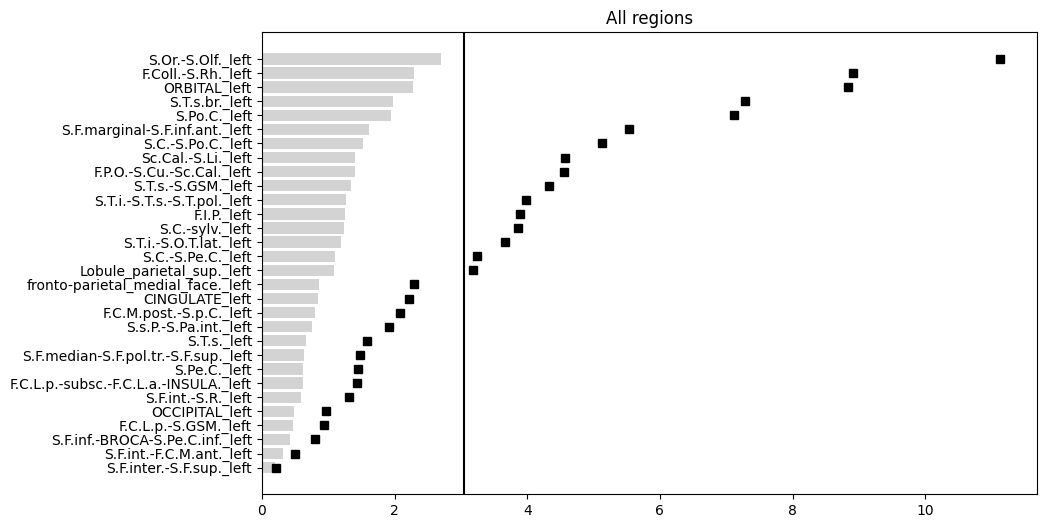

In [42]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='left'], "region", ax, "f_value", "f_value", "p_value",  True, "All regions")
plt.show()

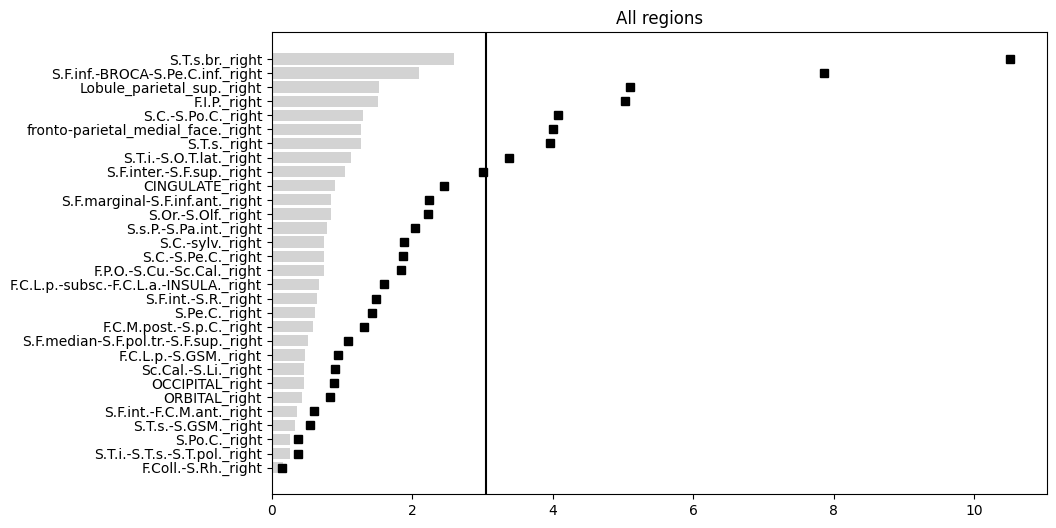

In [43]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='right'], "region", ax, "f_value", "p_value", "p_value",  True, "All regions")
plt.show()

In [44]:
# df.to_csv(output_filename)

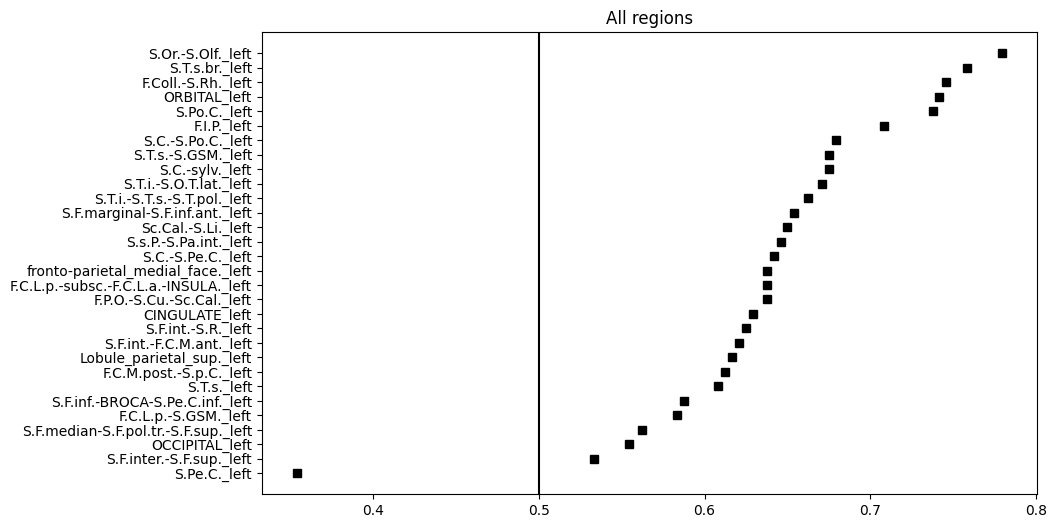

In [88]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal_auc(df_auc[df_auc.side=='left'], "region", ax, "auc", "auc", "auc",  True, "All regions")
plt.show()

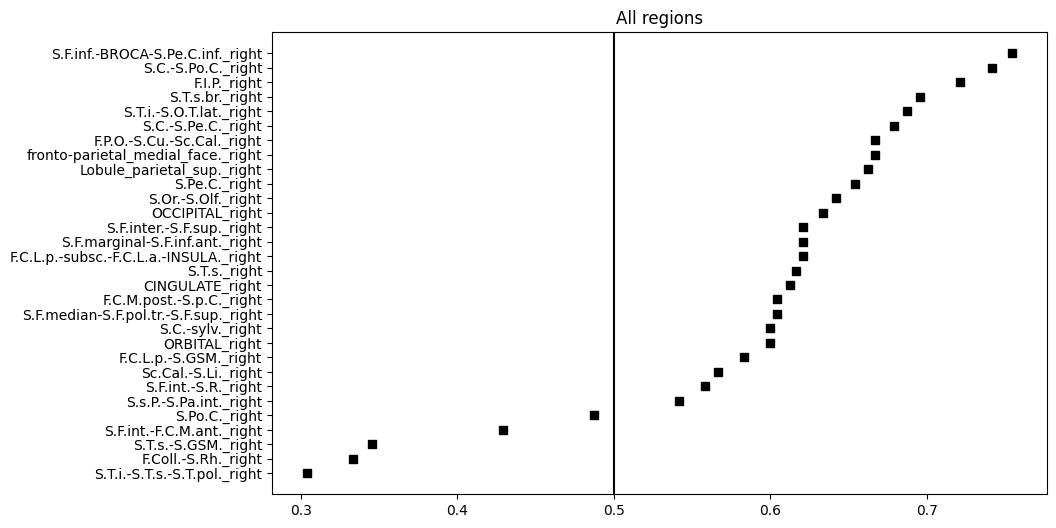

In [89]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal_auc(df_auc[df_auc.side=='right'], "region", ax, "auc", "auc", "auc",  True, "All regions")
plt.show()